100%|██████████| 170M/170M [00:01<00:00, 94.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 43.7455
Epoch [2/10], Loss: 18.6789
Epoch [3/10], Loss: 16.3786
Epoch [4/10], Loss: 15.9512
Epoch [5/10], Loss: 16.0048
Epoch [6/10], Loss: 15.6446
Epoch [7/10], Loss: 14.9699
Epoch [8/10], Loss: 15.0143
Epoch [9/10], Loss: 15.1326
Epoch [10/10], Loss: 14.6638


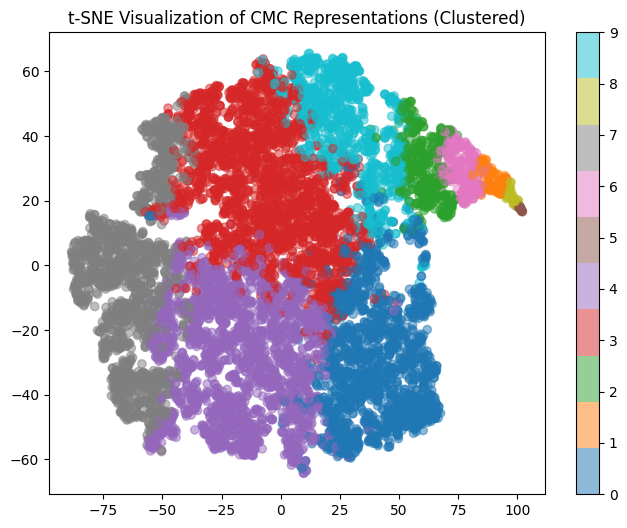

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define two different augmentations as different views
transform_view1 = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_view2 = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# CIFAR-10 Multi-View Dataset (Unsupervised)
class MultiViewDataset(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)  # Ignore class labels
        return transform_view1(img), transform_view2(img), index  # Use instance index

dataset = MultiViewDataset(root='./data', train=True, download=True)
subset_indices = torch.arange(10000)  # Ensure indices are in [0, 9999]
dataset = Subset(dataset, subset_indices)
trainloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Two Encoders (ResNet-18 for both views)
class Encoder(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=False)
        resnet.fc = nn.Linear(512, output_dim)  # Projection head
        self.encoder = resnet

    def forward(self, x):
        return self.encoder(x)

# Memory Bank for Contrastive Learning
class MemoryBank(nn.Module):
    def __init__(self, inputSize, outputSize, K=4096, T=0.07, momentum=0.5):
        super().__init__()
        self.K, self.T, self.momentum = K, max(T, 1e-6), momentum
        self.register_buffer('memory', torch.randn(outputSize, inputSize).div_(10))

    def forward(self, z_anchor, memory_bank, indices):
        batch_size = z_anchor.size(0)
        indices = indices.long()

        # Sample negatives
        neg_idx = torch.randint(0, self.memory.size(0), (batch_size, self.K), device=device)
        idx = torch.cat((indices.unsqueeze(1), neg_idx), dim=1)

        # Retrieve memory bank features
        weight = memory_bank[idx].detach()

        # Compute similarity scores
        out = torch.bmm(weight, z_anchor.unsqueeze(-1)).squeeze() / self.T

        return out

    def update_memory(self, z, indices):
        with torch.no_grad():
            indices = indices.long()
            self.memory[indices] = self.momentum * self.memory[indices] + (1 - self.momentum) * (z / z.norm(dim=1, keepdim=True))

# Contrastive Loss (Softmax-based InfoNCE)
class NCESoftmaxLoss(nn.Module):
    def __init__(self):
        super(NCESoftmaxLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, out):
        bsz = out.shape[0]
        label = torch.zeros(bsz, dtype=torch.long, device=device)
        return self.criterion(out, label)

memory_bank_view1 = MemoryBank(inputSize=128, outputSize=len(dataset), K=4096).to(device)
memory_bank_view2 = MemoryBank(inputSize=128, outputSize=len(dataset), K=4096).to(device)

encoder_view1 = Encoder().to(device)
encoder_view2 = Encoder().to(device)

criterion = NCESoftmaxLoss()
optimizer = optim.Adam(list(encoder_view1.parameters()) + list(encoder_view2.parameters()), lr=3e-4)

epochs = 10

# Training Loop
for epoch in range(epochs):
    total_loss = 0
    for img_view1, img_view2, indices in trainloader:
        img_view1, img_view2, indices = img_view1.to(device), img_view2.to(device), indices.to(device).long()
        optimizer.zero_grad()

        # Encode both views using separate encoders
        z_view1, z_view2 = encoder_view1(img_view1), encoder_view2(img_view2)

        # Compute contrastive loss (View 1 vs Memory Bank 2, View 2 vs Memory Bank 1)
        out_view1 = memory_bank_view2(z_view1, memory_bank_view2.memory, indices)  # View 1 as anchor
        out_view2 = memory_bank_view1(z_view2, memory_bank_view1.memory, indices)  # View 2 as anchor

        loss = criterion(out_view1) + criterion(out_view2)  # Two loss terms

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update memory banks
        memory_bank_view1.update_memory(z_view1.detach(), indices)
        memory_bank_view2.update_memory(z_view2.detach(), indices)

        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(trainloader):.4f}")

# Extract Features for Visualization
features, indices = [], []
with torch.no_grad():
    for img_view1, _, index in trainloader:
        img_view1 = img_view1.to(device)
        feat = encoder_view1(img_view1).cpu().numpy()
        features.append(feat)
        indices.append(index.numpy())

features = np.vstack(features)
indices = np.hstack(indices)

# Apply K-Means for Clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)

# t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of CMC Representations (Clustered)")
plt.show()